<a href="https://colab.research.google.com/github/SophinaLuitel/Comp710Group5/blob/main/AST_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:


import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import wave
import pylab
from pathlib import Path
from scipy import signal
from scipy.io import wavfile
from sklearn.metrics import confusion_matrix
import itertools

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
def extract_label_from_filename(filename):
    tem = filename.split("/", -1)

    if tem[0][2:5] == "gio":
        return 1
    elif tem[0][2:5] == "tri":
        return 0
    elif tem[0][2:5] == "ans":
        return 2
    elif tem[0][2:5] == "dis":
        return 3
    elif tem[0][2:5] == "rab":
        return 4

In [6]:
def extract_gender_rom_filename(filename):
    tem = filename.split("/", -1)

    if tem[0][0] == 'f':
        return 1
    elif tem[0][0] == 'm':
        return 0


In [7]:
from PIL import Image
import os
import numpy as np

spectrogram_images = []
labels = []
gender=[]
spectrogram_height = 256
spectrogram_width = 256
BATCH_SIZE = 32
channels = 3

output_dir = '/content/drive/MyDrive/wav_corpus/png16emo'
INPUT_DIR = '/content/drive/MyDrive/wav_corpus/png16emo'

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

for filename in os.listdir(INPUT_DIR):
    if filename.endswith(".png"):
        img_path = os.path.join(INPUT_DIR, filename)  # Corrected the path
        img = Image.open(img_path)
    #    print(img)

        img = img.resize((spectrogram_width, spectrogram_height))  # Resize if needed
        img_array = np.array(img)
        spectrogram_images.append(img_array)

        label = extract_label_from_filename(filename)  # Implement this based on your naming convention
        labels.append(label)

        gen= extract_gender_rom_filename(filename)
        gender.append(gen)

spectrogram_images = np.array(spectrogram_images,dtype=np.float32)



labels = np.array(labels)
gender=np.array(gender)


In [108]:
#  image information
print("Number of images:", len(spectrogram_images))
print("Number of labels:", len(labels))
print("Number of gender:", len(gender))

spectrogram_images = np.array(spectrogram_images)
labels = np.array(labels)
#print(labels)
# information after array conversion
print("Shape of spectrogram_images array:", spectrogram_images.shape)
print("Shape of labels array:", labels.shape)

Number of images: 494
Number of labels: 494
Number of gender: 494
Shape of spectrogram_images array: (494, 256, 256, 3)
Shape of labels array: (494,)


In [109]:
# Define the two emotions you want to keep
emotions_to_keep = [0, 1]  # Replace with the actual label values for the two emotions

# Filter the spectrogram images and labels for the two emotions
filtered_indices = np.isin(labels, emotions_to_keep)
spectrogram_images = spectrogram_images[filtered_indices]
labels = labels[filtered_indices]
gender = gender[filtered_indices]

print(f"Filtered spectrograms shape: {spectrogram_images.shape}")
print(f"Filtered labels shape: {labels.shape}")
print(f"Filtered gender shape: {gender.shape}")


Filtered spectrograms shape: (494, 256, 256, 3)
Filtered labels shape: (494,)
Filtered gender shape: (494,)


In [110]:
from sklearn.model_selection import train_test_split

# Split the data into training and temporary validation sets
train_images, temp_images, train_labels, temp_labels = train_test_split(spectrogram_images, labels, test_size=0.2, random_state=42)

# Split the temporary validation set into validation and test sets
val_images, test_images, val_labels, test_labels = train_test_split(temp_images, temp_labels, test_size=0.5, random_state=42)

# Print the shapes of the resulting datasets
print("Train set shape:", train_images.shape, train_labels.shape)
print("Validation set shape:", val_images.shape, val_labels.shape)
print("Test set shape:", test_images.shape, test_labels.shape)

Train set shape: (395, 256, 256, 3) (395,)
Validation set shape: (49, 256, 256, 3) (49,)
Test set shape: (50, 256, 256, 3) (50,)


In [111]:
print(spectrogram_images.shape)
print(labels.shape)
# Assuming y_labels is a NumPy array or list of labels
labels1, counts = np.unique(labels, return_counts=True)

# Print the counts for each label
for label, count in zip(labels1, counts):
    print(f"Label {label}: {count} data points")

(494, 256, 256, 3)
(494,)
Label 0: 254 data points
Label 1: 240 data points


In [126]:
import random

from tensorflow.keras.optimizers import SGD, RMSprop, Adagrad, Nadam,Adam
import tensorflow as tf
from tensorflow.keras import regularizers
import numpy as np

# Set random seed for TensorFlow
tf.random.set_seed(42)

# Set random seed for numpy
np.random.seed(42)
# Set random seed
random.seed(42)

# Define the CNN model
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(256, 256, 3)),

    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='valid',kernel_regularizer=regularizers.l1_l2(l1=1e-4,l2=1e-3)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.2),

    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='valid',kernel_regularizer=regularizers.l1_l2(l1=1e-4,l2=1e-3)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.2),

    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='valid',kernel_regularizer=regularizers.l1_l2(l1=1e-4,l2=1e-3)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.2),


    #flatten layer to transition from convolution to dense layer
    tf.keras.layers.Flatten(),
    #fully connected layers with the dropout for regularization
    tf.keras.layers.Dense(64, activation='relu',kernel_regularizer=regularizers.l1_l2(l1=1e-3,l2=1e-3)),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
learning_rate=1e-4
optimizer=Adam(learning_rate=learning_rate)
# Compile the model

model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

#print(model.summary())


In [127]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Early stopping to prevent overfitting
#early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Reduce learning rate when a metric has stopped improving
#reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-4)
# Train the model
history=model.fit(train_images, train_labels, epochs=30, batch_size=8, validation_data=(val_images, val_labels))

# Evaluate the model
loss, accuracy = model.evaluate(val_images, val_labels)
print("Validation accuracy:", accuracy)

Epoch 1/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 15s 153ms/step - accuracy: 0.5338 - loss: 19.7650 - val_accuracy: 0.5714 - val_loss: 16.1032
Epoch 2/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.7228 - loss: 15.1241 - val_accuracy: 0.5714 - val_loss: 12.8113
Epoch 3/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.7085 - loss: 12.1911 - val_accuracy: 0.6327 - val_loss: 10.6884
Epoch 4/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.7745 - loss: 10.2172 - val_accuracy: 0.8980 - val_loss: 8.9424
Epoch 5/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.7985 - loss: 8.7315 - val_accuracy: 0.9184 - val_loss: 7.7078
Epoch 6/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.7873 - loss: 7.4559 - val_accuracy: 0.8776 - val_loss: 6.6948
Epoch 7/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.8813 - loss: 6.4115 - val_accuracy: 0.8980 - val_loss: 5.8235
Epoch 8/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.8518 - loss: 5.6158 - val_accuracy: 0

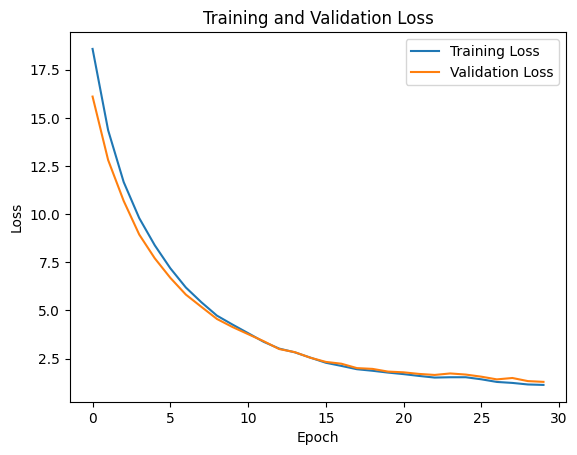

In [128]:
# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 280ms/step
Validation accuracy during inference: 0.9
=== Confusion Matrix ===
[[25  3]
 [ 2 20]]




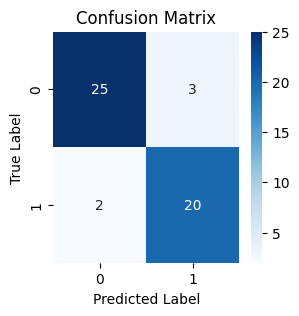

=== Classification Report ===
              precision    recall  f1-score   support

           0       0.93      0.89      0.91        28
           1       0.87      0.91      0.89        22

    accuracy                           0.90        50
   macro avg       0.90      0.90      0.90        50
weighted avg       0.90      0.90      0.90        50





In [129]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
# Generate predictions using the trained model
predictions = model.predict(test_images)
#print(predictions)
# Convert probability predictions to class labels
predicted_labels = (predictions > 0.5).astype(int)

# Evaluate the performance on the test set
accuracy = np.mean(predicted_labels.flatten() == test_labels)
print("Validation accuracy during inference:", accuracy)

# Generate confusion matrix
conf_matrix = confusion_matrix(test_labels, predicted_labels)

# Print confusion matrix
print("=== Confusion Matrix ===")
print(conf_matrix)
print('\n')

# Plot confusion matrix using seaborn
plt.figure(figsize=(3, 3))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(test_labels), yticklabels=np.unique(test_labels))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
print("=== Classification Report ===")
print(classification_report(test_labels, predicted_labels))
print('\n')
